#   NVD Introduction

## Introduction

Vulnerabilities data are available in three different sources: CVE Mitre, NVD and CVE Details, being created and
annotated through the data sources in this respective order.

Launched in 1999 when most information security tools used their own databases with their own names for security vulnerabilities, the **Common Vulnerabilities and Exposures (CVE) by Mitre** documents known vulnerabilities
manually for public usage. 

Each vulnerability contains a description, is uniquely identified by a CVE ID, and may also include fields specifying the vulnerable software, version and vendors affected by it. If a set of vulnerabilities
are similar, but occur for different software, they can have different CVE-IDs, and contain the same weakness ID (CWE ID). 

When created by CVE Mitre, each vulnerability may or not be annotated with a weakness ID(CWE ID),but when available they can serve to group similar vulnerabilities conceptually,and observe how they have been ‘instantiated’ in different software, version or vendor.

CVE Mitre’s vulnerabilities are then annotated with severity scores, fix information,
and impact ratings in the **National Vulnerability Database(NVD)**,and made available for download as XML feeds.

**CVE Details** was created to provide a user-friendly interface to NVD’s XML feeds. For instance, using vulnerabilities’ CWE IDs and keyword matching, it defines 13 vulnerability types to facilitate browsing vulnerabilities. Since CVE Details warns about inconsistencies in NVD XML Feeds (e.g.same vendor’s software having different names), and irrelevant entries to our purposes (i.e. reserved, duplicates and removed entries), we downloaded all software vulnerabilities to date from the three sources to define our vulnerability dataset and ensure consistency.


## Motivation

NVD data has about 60,000 vulnerability entries (CVE Mitre's RESERVED entries not included), but it is more important to understand the weakness they are associated with (CWE IDs). By evaluating the CWE ID coverage over given CVE IDs, across the timeline, we can gain insights about active months or years (in terms of number of entries) and it's correlation to CWE coverage (if any)!

## Method

### Parsing XML files to CVS

The data from the NVD website is available for each year from 2002 up to 2017 in XML format. To perform further analysis, we require few fields (CVE-ID, CWE-ID,Timestamp) to be extracted, thus we will parse only those tags from XML to CSV. The code below has demostrated conversion and extraction for the years 2002 to 2017 (Feb), and the files after conversion will be found in the same folder as the notebook exists identifyable with the name of the year. The range of years or the destination folder to be copied can be changed by althering the path and the numbers mentioned in the code. 
The below method uses ElementTree for XML parsing.
If you choose to skip this step and access the CSV files directly, you can find them on our [Google Drive](https://drive.google.com/open?id=0B-NONBqqQBznYlRLUU5zS0lLZU0).

In [3]:
#Parsing using ElelmentTree
import xml.etree.ElementTree as ET
import csv

In [4]:
#getting all XML files in a python list
import glob
x = glob.glob("raw_data/*.xml")

In [6]:
#extarcting fields and writing them into a CSV file
yearRange =2002;
for y in x:
    CVE_tree = ET.parse(y)
    CVE_root= CVE_tree.getroot()
    f = open(str(yearRange)+".csv", 'w');
    yearRange= yearRange+1;
    CVE_count = 0;
    CVE_listOfId = [];
    for entry in CVE_root:
        cve_id = "";
        cwe_id = "";
        modified_date = "";
        cvss = "";
        for child in entry:
        #Print Child.tag will help you code further to identify child nodes
        #print (child.tag) 
            root = '{http://scap.nist.gov/schema/vulnerability/0.4}';
            childList = ['cve_id','published-datetime'];
            
            if (child.tag == '{http://scap.nist.gov/schema/vulnerability/0.4}cve-id'):
                cve_id = child.text;
            if (child.tag == '{http://scap.nist.gov/schema/vulnerability/0.4}cwe'):
                cwe_id = child.attrib['id'];        
            if (child.tag == '{http://scap.nist.gov/schema/vulnerability/0.4}summary'):
                modified_date = child.text;
            
    #Dont write header if you will be using the merged database
    #Head = "CVE ID,CWE ID,Timestamp\n";
    #f.write(Head);
        vuln = '{o1},{o2},{o3}\n'.format(o1=cve_id,o2=cwe_id,o3=modified_date);
        f.write(vuln);
        CVE_count = CVE_count +1;
    #print (CVE_count)
    f.close();
    

In [7]:
#merge all years into one
#only perform if data is required for all years
fout=open("Merged_2002-17.csv","a")
# first file:
Head = "CVE ID,CWE ID,Summary\n";
fout.write(Head);
for line in open("2002.csv"):
    fout.write(line)
# now the rest:    
for num in range(2003,2017):
    f = open(str(num)+".csv")
    #f.next() # skip the header
    for line in f:
         fout.write(line)
    f.close() # not really needed
fout.close()

## Histograms by Month

In [8]:
#using panda 
import pandas as pd
import csv

In [9]:
#We first load all file paths
import glob
nvd_filepaths = glob.glob("data/*.csv")
#Then we prepare a list, that will contain all the tables that exist in these file paths
nvd_dataframes = []
for nvd_filepath in nvd_filepaths:
    #the csvs do not contain headers, so are added here. TO-DO: Add headers to CSV when they are generated.
    nvd_dataframes.append(pd.read_csv(nvd_filepath,names=['cve_id', 'cwe_id','timestamp']))


For the sake of clarity, let's consider just one of the dataframes in the list of dataframes to show how the percent is done. 

In [10]:
#Choose the first dataframe at position 0
nvd_df = nvd_dataframes[0]
#Parse the timestamp field turning it into a datetimeindex object, and then access the month attribute
nvd_df['month'] = pd.DatetimeIndex(nvd_df['timestamp']).month

#Now that we have a month column, we can 'group by' the table by the month column. 
nvd_df = nvd_df.groupby(by=['month'])['cve_id','cwe_id'].count()
nvd_df

,cve_id,cwe_id
month,,
1,674,182
2,458,110
3,608,145
4,637,98
5,572,90
6,566,94
7,571,98
8,529,152
9,446,401


In [11]:
#All that is left is divide row-wise the number of cwe_ids, by the numter of cve_ids. 
#Since the cwe_ids are never null, then they effectively represent the number of rows for the given month. 
#cwe_id, instead, that can be null, will only counted when it occurs. 
#Dividing one by the other, gives us the cwe_coverage we desire for the timeseries.
nvd_df['cwe_coverage'] = nvd_df['cwe_id']/nvd_df['cve_id']
nvd_df

,cve_id,cwe_id,cwe_coverage
month,,,
1,674,182,0.270030
2,458,110,0.240175
3,608,145,0.238487
4,637,98,0.153846
5,572,90,0.157343
6,566,94,0.166078
7,571,98,0.171629
8,529,152,0.287335
9,446,401,0.899103


Let's define a function with the code above, so that given a dataframe, it generates the table above, with cve_id,_cwe_id, and cwe_coverage. 

In [12]:
def calculate_cwe_coverage(nvd_df):
    #Parse the timestamp field turning it into a datetimeindex object, and then access the month attribute
    nvd_df['month'] = pd.DatetimeIndex(nvd_df['timestamp']).month
    #Now that we have a month column, we can 'group by' the table by the month column. 
    nvd_df = nvd_df.groupby(by=['month'])['cve_id','cwe_id'].count()
    nvd_df['cwe_coverage'] = nvd_df['cwe_id']/nvd_df['cve_id']
    return nvd_df
    

Now we generate the cwe coverage table for all our dataframes in our list.

In [13]:
cwe_coverage_dfs = []
for nvd_df in nvd_dataframes: 
    cwe_coverage_dfs.append(calculate_cwe_coverage(nvd_df))
#cwe coverage for the 3rd dataset.
print(cwe_coverage_dfs)

[       cve_id  cwe_id  cwe_coverage
month                              
1         674     182      0.270030
2         458     110      0.240175
3         608     145      0.238487
4         637      98      0.153846
5         572      90      0.157343
6         566      94      0.166078
7         571      98      0.171629
8         529     152      0.287335
9         446     401      0.899103
10        573     478      0.834206
11        426     370      0.868545
12        450     392      0.871111,        cve_id  cwe_id  cwe_coverage
month                              
1         640     547      0.854688
2         844     800      0.947867
3         745     673      0.903356
4         663     582      0.877828
5         423     393      0.929078
6         458     434      0.947598
7         561     501      0.893048
8         622     580      0.932476
9         566     497      0.878092
10        527     458      0.869070
11        450     424      0.942222
12        535     499     

We now have all the information needed to plot our timeseries. 

# CWE Coverage Timeseries

In [14]:
#imports for histogram
import numpy as np
import pandas as pd
from bokeh.plotting import figure, show
from bokeh.models import Range1d
from bokeh.io import output_notebook
from bokeh.charts import Bar
import matplotlib.pyplot as plot
from datetime import datetime
output_notebook() 

Loading BokehJS ...

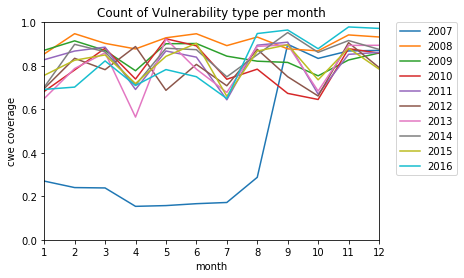

In [15]:
color_map = {
'2007': 'red',
'2008': 'green',
'2009': 'yellow',
'2010': 'violet',
'2011': 'indigo',
'2012': 'brown',
'2013': 'black',
'2014': 'blue',
'2015': 'orange',
'2016': 'olive',
'2017': 'navy',
}

def create_multi_line(vul):
    vul_plot = plot.subplot(111)
    map={}
    year = 2006;
    for frame in cwe_coverage_dfs:
        year+=1;
        map[year]= frame['cwe_coverage']
        vul_plot.plot(map[year], label = year )
    vul_plot.set_ylabel('cwe coverage')
    vul_plot.set_xlabel('month')
    vul_plot.legend(bbox_to_anchor=(1.05, 1),loc=2, borderaxespad=0.)
    vul_plot.set_title("Count of Vulnerability type per month")
    vul_plot.set_autoscaley_on(False)
    vul_plot.set_ylim([0,1])
    vul_plot.set_autoscalex_on(False)
    vul_plot.set_xlim([1,12])
    vul_plot.xaxis.set_ticks([1,2,3,4,5,6,7,8,9,10,11,12])   
    plot.show()

create_multi_line(cwe_coverage_dfs)

